# Comparison of performance and temperature evolutions on G5K clusters

In [1]:
import io
import zipfile
import pandas
import yaml
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    result = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    result['index'] = range(len(result))
    info = get_yaml(archive_name, 'info.yaml')
    hostname = [k for k in info if k.endswith('grid5000.fr')]
    assert len(hostname) == 1
    idx = hostname[0].index('.')
    hostname = hostname[0][:idx]
    idx = hostname.index('-')
    node = int(hostname[idx+1:])
    cluster = hostname[:idx]
    result['hostname'] = hostname
    result['node'] = node
    result['cluster'] = cluster
    result['jobid'] = info['jobid']
    result['filename'] = archive_name
    result['start'] = pandas.to_datetime(result['start'])
    result['stop'] = pandas.to_datetime(result['stop'])
    return result

def read_result(name, exp_id=0):
    perf = read_csv(name, 'stress_perf_%d.csv' % exp_id)
    temp = read_csv(name, 'stress_temp_%d.csv' % exp_id)
    min_time = min(perf.start.min(), temp.start.min())
    for df in [perf, temp]:
        for name in ['start', 'stop']:
            df[name] -= min_time
    return perf, temp

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

directory = 'data/1/'
exp_files = [directory + filename for filename in os.listdir(directory)]
results = [read_result(filename) for filename in exp_files]

perf = pandas.concat([t[0] for t in results])
temp = pandas.concat([t[1] for t in results])
perf.head()

,start,stop,duration,gflops,index,hostname,node,cluster,jobid,filename
0,00:00:00.000226,00:00:11.114728,11.114467,791.409366,0,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip
1,00:00:11.115060,00:00:22.212770,11.097680,792.606468,1,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip
2,00:00:22.228252,00:00:33.377660,11.149350,788.933230,2,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip
3,00:00:33.396587,00:00:44.548755,11.152113,788.737764,3,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip
4,00:00:44.549056,00:00:55.716563,11.167475,787.652774,4,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip


In [2]:
temp.head()

,start,stop,sensor_id,temperature,index,hostname,node,cluster,jobid,filename
0,00:00:00,00:00:00.000166,0,41.0,0,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip
1,00:00:00,00:00:00.000166,1,44.0,1,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip
2,00:00:11.114856,00:00:11.115037,0,49.0,2,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip
3,00:00:11.114856,00:00:11.115037,1,54.0,3,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip
4,00:00:22.212878,00:00:22.213054,0,52.0,4,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip


## Visualizing the data

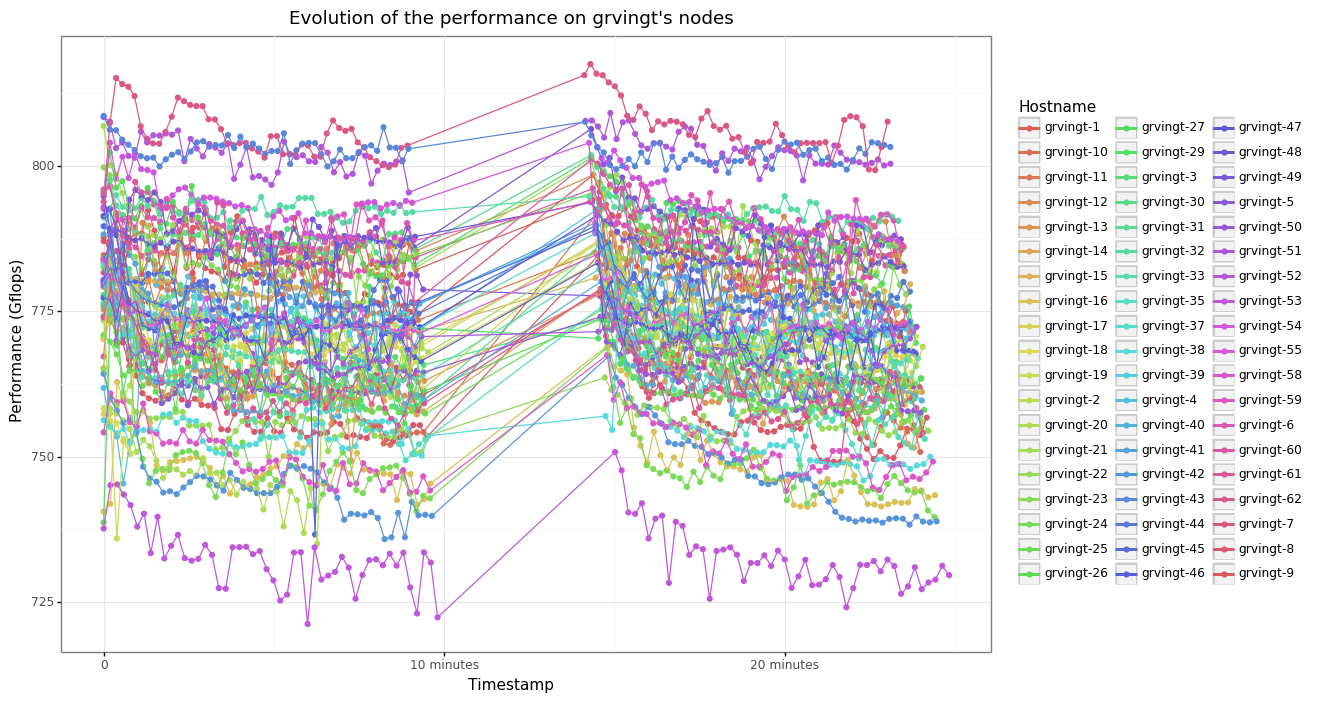

<ggplot: (8780626023649)>

In [3]:
plot = ggplot(perf, aes(x='start', y='gflops', color='factor(hostname)', group='jobid')) + geom_point() + geom_line() + theme_bw()
plot + xlab('Timestamp') + ylab('Performance (Gflops)') + labs(color='Hostname') + ggtitle("Evolution of the performance on %s's nodes" % perf.cluster.unique()[0])

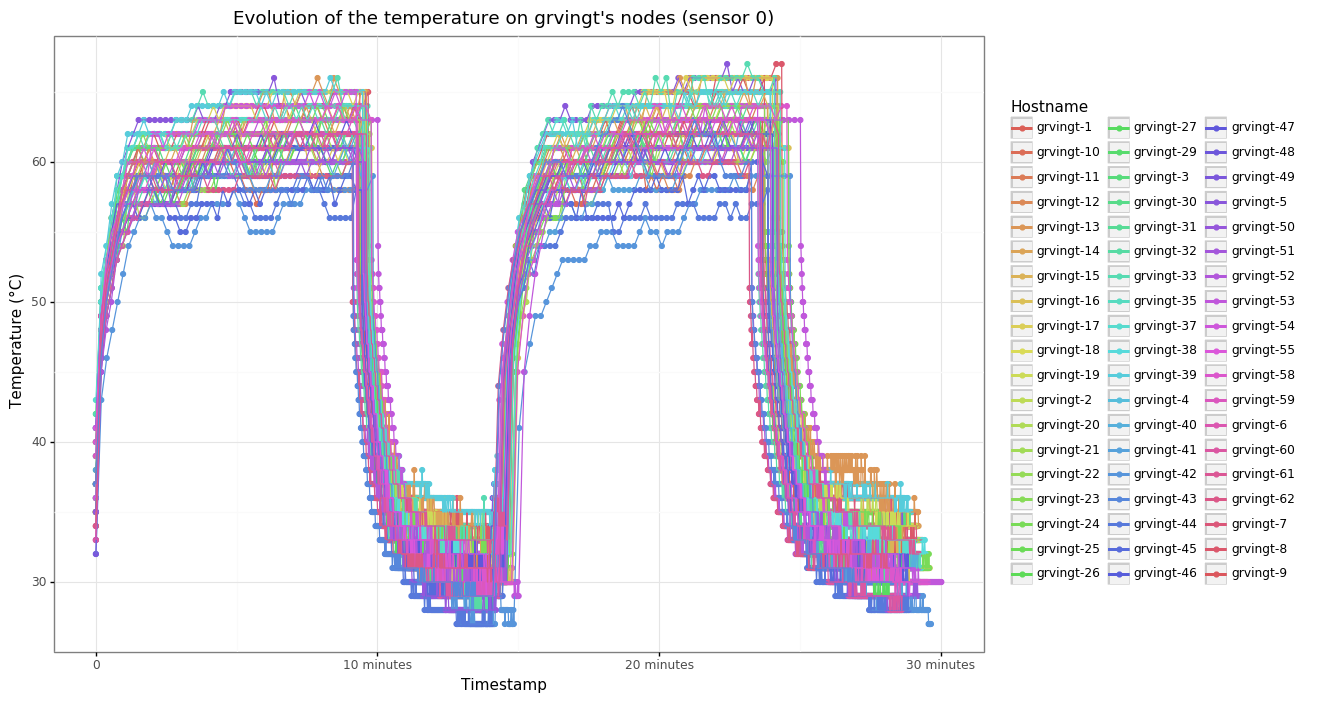

<ggplot: (8780625964215)>


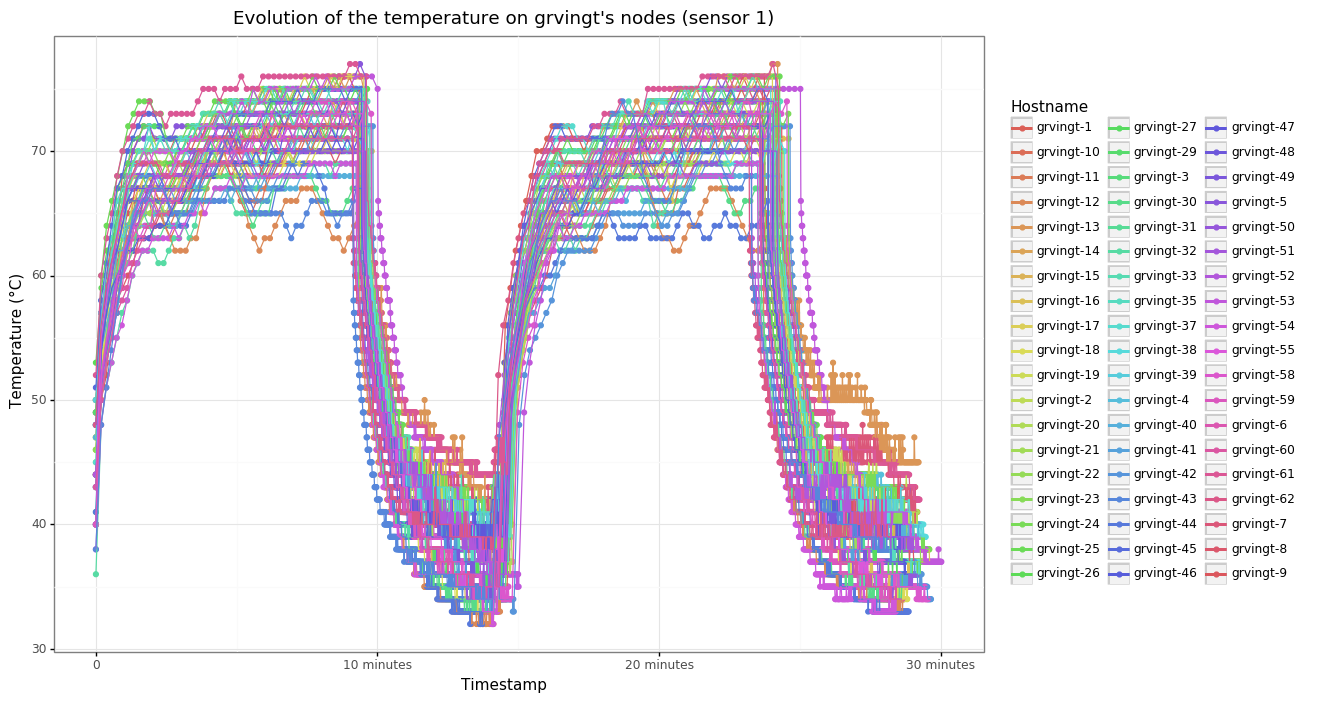

<ggplot: (8780625994802)>


In [4]:
for sensor in temp.sensor_id.unique():
    plot = ggplot(temp[temp.sensor_id == sensor], aes(x='start', y='temperature', color='factor(hostname)', group='jobid')) + geom_point() + geom_line() + theme_bw()
    plot = plot + xlab('Timestamp') + ylab('Temperature (°C)') + labs(color='Hostname') + ggtitle("Evolution of the temperature on %s's nodes (sensor %d)" % (perf.cluster.unique()[0], sensor))
    print(plot)

In [5]:
def compute_avg_temp(perf_df, temp_df, sensor_id=1):
    new_perf = []
    for host in perf_df.hostname.unique():
        perf = perf_df[perf_df.hostname == host].copy()
        perf['kind'] = 'perf'
        temp = temp_df[(temp_df.hostname == host) & (temp_df.sensor_id==sensor_id)].copy()
        temp['kind'] = 'temp'
        df = pandas.concat([perf, temp]).sort_values(by='start').reset_index(drop=True)
        idx = df[df.kind == 'perf'].index
        perf['temp_before'] = df.iloc[idx-1].temperature.reset_index(drop=True)
        perf['temp_after'] = df.iloc[idx+1].temperature.reset_index(drop=True)
        perf['avg_temp'] = (perf.temp_before + perf.temp_after)/2
        new_perf.append(perf)
    return pandas.concat(new_perf)

In [6]:
df = compute_avg_temp(perf, temp)
df.head()

,start,stop,duration,gflops,index,hostname,node,cluster,jobid,filename,kind,temp_before,temp_after,avg_temp
0,00:00:00.000226,00:00:11.114728,11.114467,791.409366,0,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip,perf,44.0,54.0,49.0
1,00:00:11.115060,00:00:22.212770,11.097680,792.606468,1,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip,perf,54.0,59.0,56.5
2,00:00:22.228252,00:00:33.377660,11.149350,788.933230,2,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip,perf,59.0,61.0,60.0
3,00:00:33.396587,00:00:44.548755,11.152113,788.737764,3,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip,perf,61.0,63.0,62.0
4,00:00:44.549056,00:00:55.716563,11.167475,787.652774,4,grvingt-48,48,grvingt,1918413,data/1/nancy_2019-04-15_1918413.zip,perf,63.0,65.0,64.0


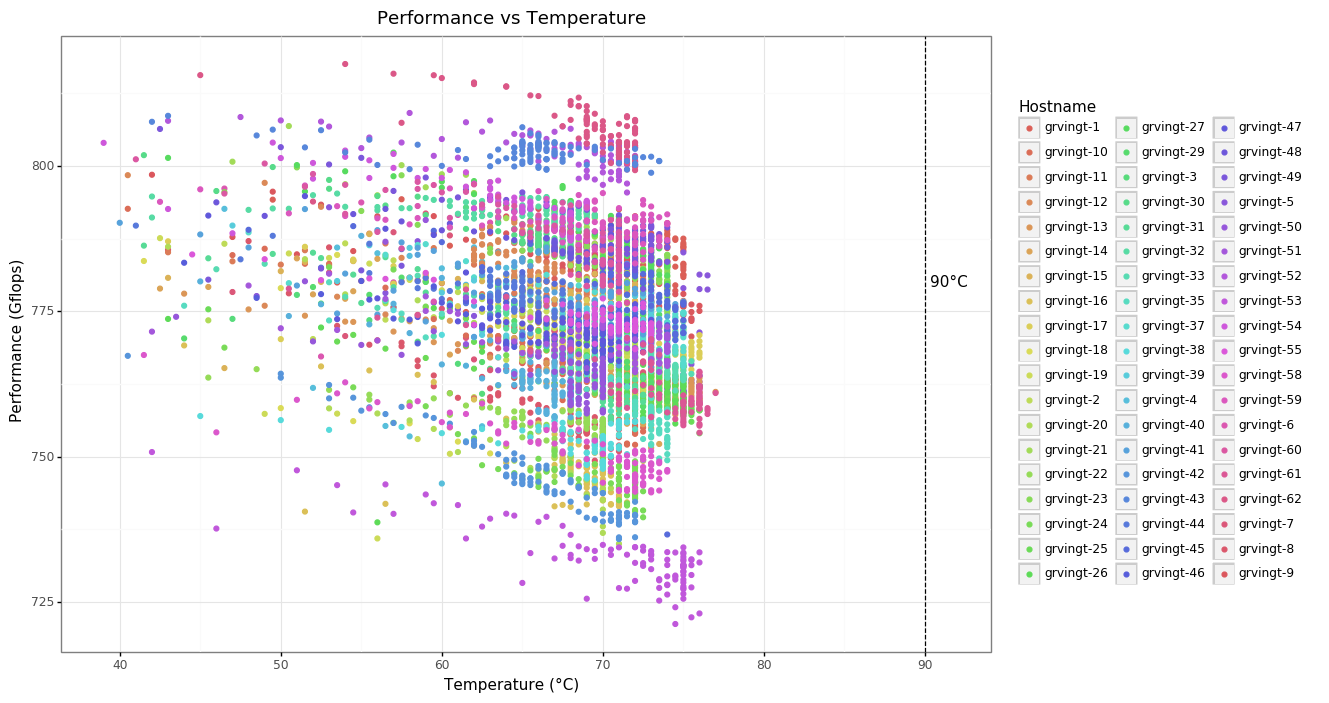

<ggplot: (-9223363256228784675)>

In [7]:
plot = ggplot(df, aes(x='avg_temp', y='gflops', color='factor(hostname)', group='jobid')) + geom_point() + theme_bw()
plot = plot + xlab('Temperature (°C)') + ylab('Performance (Gflops)') + labs(color='Hostname') + ggtitle("Performance vs Temperature")
plot = plot + geom_vline(xintercept=90, linetype='dashed') + annotate('text', label='90°C', x=91.5, y=780)
plot

## Correlation coefficients for temperature & performance

In [8]:
cor_coeff = df.groupby('node')[['avg_temp', 'gflops']].corr().iloc[0::2,-1]  # using https://stackoverflow.com/a/28990872/4110059
print(cor_coeff)
print()
cor_coeff.describe()

node          
1     avg_temp   -0.074235
2     avg_temp   -0.603403
3     avg_temp   -0.760704
4     avg_temp   -0.168699
5     avg_temp   -0.535844
6     avg_temp   -0.269302
7     avg_temp   -0.778847
8     avg_temp   -0.941691
9     avg_temp   -0.768830
10    avg_temp   -0.931711
11    avg_temp   -0.700034
12    avg_temp   -0.234803
13    avg_temp   -0.895370
14    avg_temp   -0.828056
15    avg_temp   -0.377127
16    avg_temp   -0.648360
17    avg_temp   -0.757767
18    avg_temp   -0.170990
19    avg_temp   -0.369011
20    avg_temp   -0.212290
21    avg_temp   -0.791621
22    avg_temp   -0.720128
23    avg_temp   -0.781736
24    avg_temp   -0.784849
25    avg_temp   -0.874743
26    avg_temp   -0.476507
27    avg_temp   -0.838346
29    avg_temp   -0.372522
30    avg_temp   -0.900677
31    avg_temp   -0.897332
32    avg_temp   -0.364198
33    avg_temp   -0.862260
35    avg_temp   -0.869341
37    avg_temp   -0.789439
38    avg_temp   -0.439418
39    avg_temp   -0.742293
40    avg_tem

count    57.000000
mean     -0.642306
std       0.224463
min      -0.956241
25%      -0.795855
50%      -0.712513
75%      -0.501546
max      -0.074235
Name: gflops, dtype: float64

## Comparing with Dahu

In [9]:
directory = '../../dahu/stress_test/data/1/'
exp_files = [directory + filename for filename in os.listdir(directory)]
results = [read_result(filename) for filename in exp_files]

perf_dahu = pandas.concat([t[0] for t in results])
temp_dahu = pandas.concat([t[1] for t in results])

In [10]:
df_dahu = compute_avg_temp(perf_dahu, temp_dahu)
df_dahu.head()

,start,stop,duration,gflops,index,hostname,node,cluster,jobid,filename,kind,temp_before,temp_after,avg_temp
0,00:00:00.000216,00:00:11.700618,11.700368,751.779166,0,dahu-16,16,dahu,1859950,../../dahu/stress_test/data/1/grenoble_2019-04...,perf,61.0,71.0,66.0
1,00:00:11.700938,00:00:23.474666,11.773699,747.096827,1,dahu-16,16,dahu,1859950,../../dahu/stress_test/data/1/grenoble_2019-04...,perf,71.0,73.0,72.0
2,00:00:23.474965,00:00:35.315130,11.840136,742.904710,2,dahu-16,16,dahu,1859950,../../dahu/stress_test/data/1/grenoble_2019-04...,perf,73.0,75.0,74.0
3,00:00:35.315428,00:00:47.132701,11.817246,744.343737,3,dahu-16,16,dahu,1859950,../../dahu/stress_test/data/1/grenoble_2019-04...,perf,75.0,77.0,76.0
4,00:00:47.132998,00:00:59.040253,11.907227,738.718861,4,dahu-16,16,dahu,1859950,../../dahu/stress_test/data/1/grenoble_2019-04...,perf,77.0,77.0,77.0


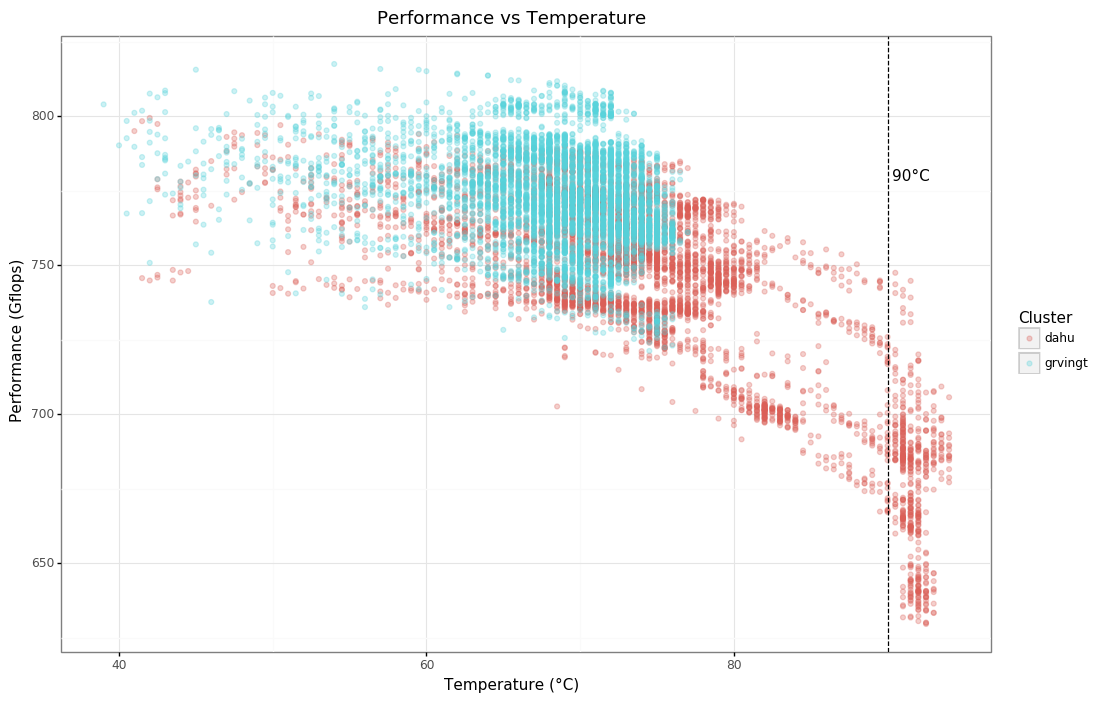

<ggplot: (-9223363256228803219)>

In [11]:
tmp = pandas.concat([df, df_dahu])
plot = ggplot(tmp, aes(x='avg_temp', y='gflops', color='cluster')) + geom_point(alpha=0.3) + theme_bw()
plot = plot + xlab('Temperature (°C)') + ylab('Performance (Gflops)') + labs(color='Cluster') + ggtitle("Performance vs Temperature")
plot = plot + geom_vline(xintercept=90, linetype='dashed') + annotate('text', label='90°C', x=91.5, y=780)
plot

Removing the slow nodes from Dahu.

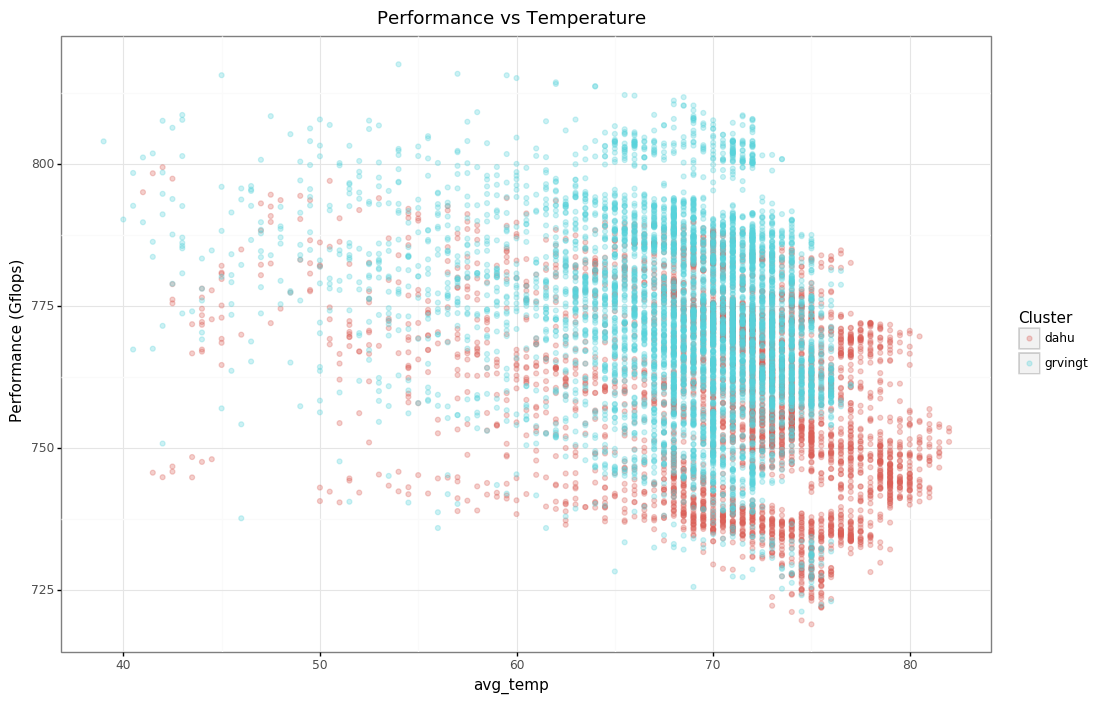

<ggplot: (-9223363256230005374)>

In [12]:
tmp = pandas.concat([df, df_dahu[~df_dahu.node.isin([13, 14, 15, 16, 25])]])
plot = ggplot(tmp, aes(x='avg_temp', y='gflops', color='cluster')) + geom_point(alpha=0.3) + theme_bw()
plot = plot + ylab('Performance (Gflops)') + labs(color='Cluster') + ggtitle("Performance vs Temperature")
plot

In [14]:
tmp = pandas.concat([df, df_dahu])
tmp = tmp.groupby('hostname')[['avg_temp', 'gflops']].agg(['min', 'median', 'max'])
tmp.columns = [('%s:%s' % col) for col in tmp.columns] #tmp.columns.droplevel(0)
tmp = tmp.reset_index()
tmp.loc[tmp.hostname.str.startswith('dahu'), 'cluster'] = 'dahu'
tmp.loc[tmp.hostname.str.startswith('grvingt'), 'cluster'] = 'grvingt'
tmp.head()

,hostname,avg_temp:min,avg_temp:median,avg_temp:max,gflops:min,gflops:median,gflops:max,cluster
0,dahu-10,47.5,72.0,74.5,755.367859,762.862654,777.822868,dahu
1,dahu-12,47.0,70.0,72.0,761.997153,774.082220,792.500755,dahu
2,dahu-13,54.5,91.5,94.0,674.644286,707.374598,782.141042,dahu
3,dahu-14,52.0,90.0,92.0,680.559858,717.515469,780.359429,dahu
4,dahu-15,54.5,90.5,93.0,629.535439,667.358197,771.479773,dahu


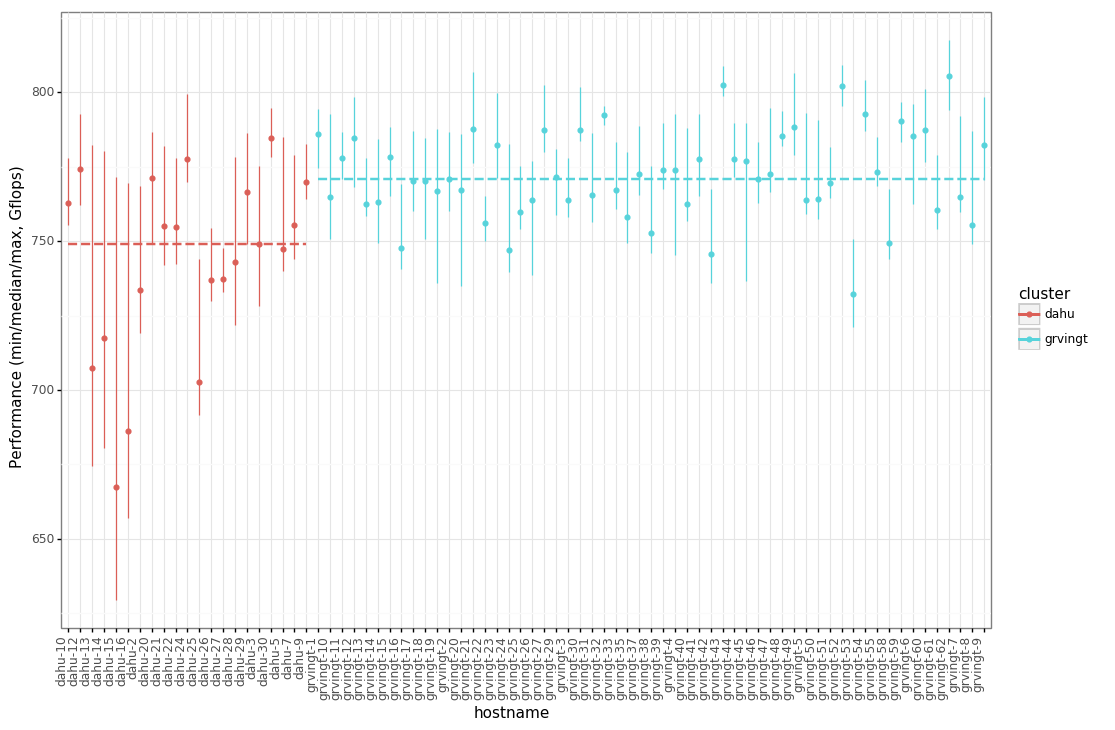

<ggplot: (-9223363256228788385)>

In [15]:
plot = ggplot(tmp, aes(x='hostname', xend='hostname', y='gflops:min', yend='gflops:max', color='cluster'))
plot = plot + geom_point(aes(y='gflops:median')) + geom_segment()
plot = plot + theme_bw() + theme(axis_text_x = element_text(angle = 90, hjust = 1))
plot = plot + ylab('Performance (min/median/max, Gflops)')
# Horizontal line:
for cluster in tmp.cluster.unique():
    tmp2 = tmp[tmp.cluster == cluster]
    df_line = pandas.DataFrame([dict(cluster=cluster, first_host=tmp2.hostname.min(), last_host=tmp2.hostname.max())])
    df_line['gflops'] = tmp2['gflops:median'].median()
    plot = plot + geom_segment(df_line, aes(x='first_host', xend='last_host', y='gflops', yend='gflops'), size=1, linetype='dashed')
plot

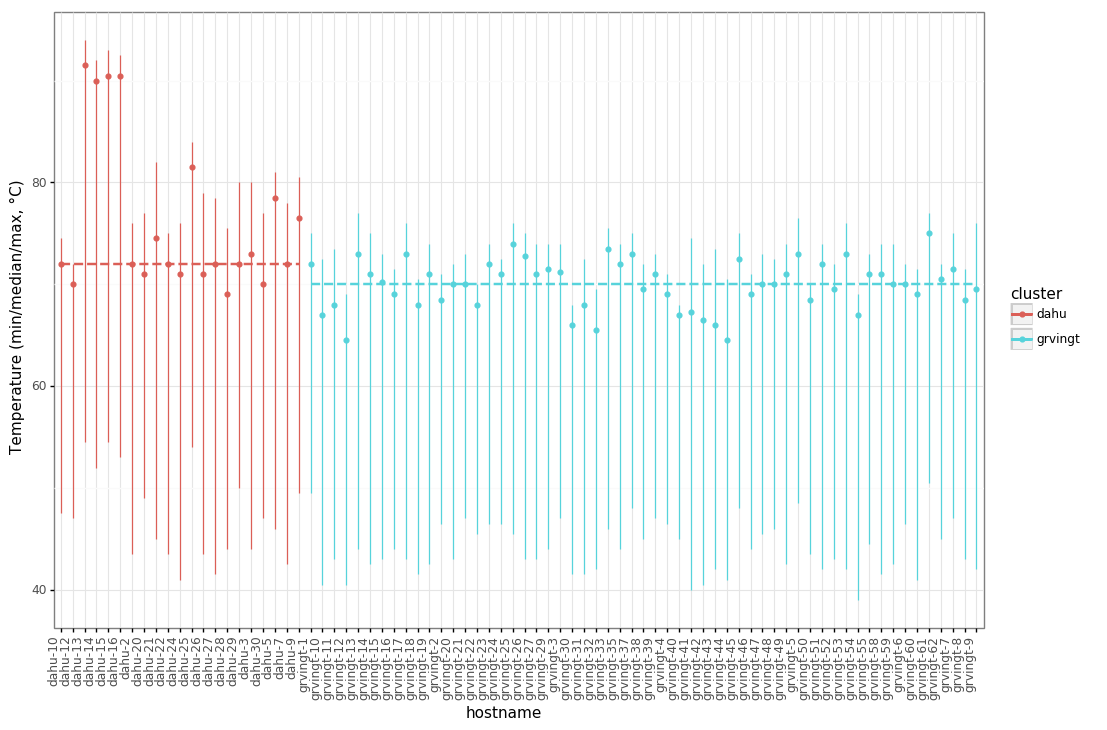

<ggplot: (-9223363256276532329)>

In [16]:
plot = ggplot(tmp, aes(x='hostname', xend='hostname', y='avg_temp:min', yend='avg_temp:max', color='cluster'))
plot = plot + geom_point(aes(y='avg_temp:median')) + geom_segment()
plot = plot + theme_bw() + theme(axis_text_x = element_text(angle = 90, hjust = 1))
plot = plot + ylab('Temperature (min/median/max, °C)')
# Horizontal line:
for cluster in tmp.cluster.unique():
    tmp2 = tmp[tmp.cluster == cluster]
    df_line = pandas.DataFrame([dict(cluster=cluster, first_host=tmp2.hostname.min(), last_host=tmp2.hostname.max())])
    df_line['temp'] = tmp2['avg_temp:median'].median()
    plot = plot + geom_segment(df_line, aes(x='first_host', xend='last_host', y='temp', yend='temp'), size=1, linetype='dashed')
plot